In [37]:

import numpy as np
import os
import pathlib
import sys
from types import SimpleNamespace
import torch
from torch.utils.data import DataLoader

from frameworks.pytorch.loggers.local_logger import LocalLogger
from frameworks.pytorch.losses.dice_loss import DiceLoss
from frameworks.pytorch.losses.focal_loss import FocalLoss
from frameworks.pytorch.metrics.mIoU import torch_mIoU
from frameworks.pytorch.utils.scales_process import torch_batch_scales_process_numpy
from platges_utils.dataloader.collate_fn.segmentation_collate import build_segmentation_test_collate
from platges_utils.datasets.argusNL_dataset import ArgusNLDataset
from platges_utils.datasets.augmented_datasets import build_test_dataset
from platges_utils.datasets.platgesbcn_segmentation_dataset import PlatgesBCNSegmentationDataset, resolve_ambiguity_platgesBCN
from platges_utils.model.pyconvsegnet import build_PyConvSegNet_from_params
from visualization_utils.save_rgb_seg import save_rgb_seg, save_rgb_err, save_rgb_ovr_seg, save_rgb_ovr_err


WATER_ID = 1
SAND_ID = 2
OTHERS_ID = 0
CLASSES_COLOR = {
    WATER_ID : 'BLUE',
    SAND_ID : 'YELLOW',
    OTHERS_ID : 'GRAY'
}

EXPERIMENT_TYPE = "segments_platgesBCN"
DATA_ROOT = "./data_lists/"
experiment_metadata = SimpleNamespace(
    dataset             = 'platgesBCN',
    loss_name           = 'dice_loss',
    model_name          = 'pyConvSegNet',
    list_path           = './data_lists/platgesbcn2021_all.csv',
    output_root         = f"./outputs/{EXPERIMENT_TYPE}/",
    segmentation_prefix = 'seg_',
    error_prefix        = 'err_',
    overlapped_prefix   = 'ovr_'
)

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
VALUE_SCALE = 255
params = SimpleNamespace(
    # Parameters updated from data
    mean = [item * VALUE_SCALE for item in MEAN],
    std = [item * VALUE_SCALE for item in STD],
    # Modifiable hyperparams:
    # (add new hyperparameters for any optim, loss, etc)
    num_classes = 3,
    gamma = 2, # if focal_loss
    stride_rate = 2/3,
    scales = [1.0],
    # Data Augmentation parameters:
    resize_height = 512,
    resize_width = 696,
    crop_height = 473,
    crop_width = 473,
    # PyConvSegNet hyperparams:
    funnel_map = True,
    zoom_factor = 8,
    layers = 152,
    num_classes_pretrain = 150,
    backbone_output_stride = 8,
    backbone_net = "pyconvresnet",
    # Pre-trained pathes
    pretrained_back_path = 'model_parameters/original_pyconvsegnet/ade20k_trainval120epochspyconvresnet152_pyconvsegnet.pth',
    adapt_state_dict = True,
    pretrained_path = None
)

####################################

def save_result(input_, output, target, img_path, experiment_metadata, classes_color=CLASSES_COLOR):
    # input_ from torch standard (C, H, W)
    # output as image mask (H, W)
    # target as image mask (H, W)

    output = output.squeeze().numpy().astype(np.uint8)
    target = target.squeeze().numpy().astype(np.uint8)
    input_ = input_.squeeze().permute(1, 2, 0).numpy().astype(np.uint8)

    folder = experiment_metadata.output_root
    seg_prefix = experiment_metadata.segmentation_prefix
    err_prefix = experiment_metadata.error_prefix
    ovr_prefix = experiment_metadata.overlapped_prefix

    # Save images
    save_rgb_seg(f"{folder}/{seg_prefix}{os.path.basename(img_path)}", output, classes_color)
    save_rgb_err(f"{folder}/{err_prefix}{os.path.basename(img_path)}", output, target)
    save_rgb_ovr_seg(f"{folder}/{ovr_prefix}{seg_prefix}{os.path.basename(img_path)}", input_, output, classes_color)
    save_rgb_ovr_err(f"{folder}/{ovr_prefix}{err_prefix}{os.path.basename(img_path)}", input_, output, target, classes_color)

def get_postprocess_output_and_target_funct(dataset):
    if dataset == 'platgesBCN':
        return lambda output, target : resolve_ambiguity_platgesBCN(output, target, resolve=False)
    #elif dataset == '':
    else:
        return None

def get_base_dataset_type(dataset):
    if dataset == 'argusNL':
        return ArgusNLDataset
    elif dataset == 'platgesBCN':
        return PlatgesBCNSegmentationDataset
    else:
        raise Exception(f"Undefined dataset: {dataset}\nMaybe it is defined but not contemplated on the script (experiment).")

def get_model_type(model_name):
    if model_name == 'pyConvSegNet':
        return build_PyConvSegNet_from_params
    #elif model_name == :
    else:
        raise Exception(f"Undefined model_name: {model_name}\nMaybe it is defined but not contemplated on the script (experiment).")

In [38]:
device = torch.device('cpu')

base_dataset_type = get_base_dataset_type(experiment_metadata.dataset)
dataset = base_dataset_type(experiment_metadata.list_path)
dataset = build_test_dataset(dataset, params.resize_height, params.resize_width, params.mean, params.std)

collate_fn = build_segmentation_test_collate(device=device)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)

model_type = get_model_type(experiment_metadata.model_name)
model = model_type(params)

criterion = lambda output, target : 1234

metrics_funct_dict = {'mIoU' : torch_mIoU} # model applier torch_batch_scales_process_numpy already has argmax(C)
local_logger = LocalLogger(metrics_funct_dict.copy(), len(dataset), prefix="Test")

def model_applier(batch_images):
    output = torch_batch_scales_process_numpy(model, batch_images, params.num_classes, params.crop_height, params.crop_width, params.mean, params.std, params.scales, base_size=0, stride_rate=params.stride_rate, device=device)
    return torch.tensor(np.array(output))

postprocess_output_and_target_funct = get_postprocess_output_and_target_funct(experiment_metadata.dataset)


In [50]:
with torch.no_grad():
    for input_, target, img_pathes in dataloader:
        output = model_applier(input_)

        if postprocess_output_and_target_funct is not None:
            output2, target2 = postprocess_output_and_target_funct(output.detach().clone(), target.detach().clone())
        break

input_ = input_[0].permute(1, 2, 0)
output = output[0]
output2 = output2[0]
target = target[0]
target2 = target2[0]
        

In [51]:
ori_input_ = input_.detach().clone()
ori_output = output.detach().clone()
ori_output2 = output2.detach().clone()
ori_target = target.detach().clone()
ori_target2 = target2.detach().clone()

In [52]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt

def unNormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
    return tensor

In [53]:
print(f'params.mean: {params.mean}\nparams.std: {params.std}')

params.mean: [123.675, 116.28, 103.53]
params.std: [58.395, 57.120000000000005, 57.375]


input_.shape : (512, 696, 3)
type(input_) : <class 'numpy.ndarray'>


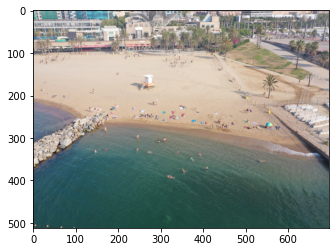

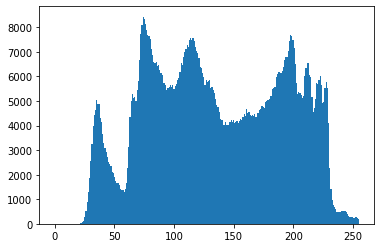

In [54]:
input_ = ori_input_.detach().clone()
input_ = unNormalize(input_.permute(2, 0, 1), params.mean, params.std).permute(1, 2, 0)
input_ = (input_.numpy() * 256).astype(np.uint8)
print(f'input_.shape : {input_.shape}\ntype(input_) : {type(input_)}')
plt.imshow(input_)
plt.show()
plt.hist(input_.flatten(), bins=256)#, range=(0, 255))
plt.show()

0
3


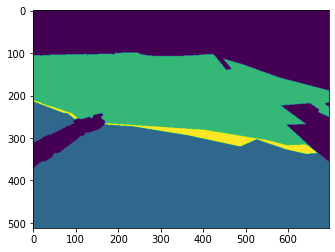

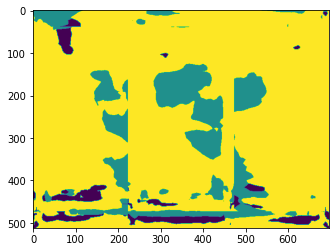

In [57]:
print(np.min(target.numpy()))
print(np.max(target.numpy()))
plt.imshow(target.numpy())
plt.show()
plt.imshow(output.numpy())
plt.show()

new_output.shape : torch.Size([1, 512, 696])
ew_target.shape : torch.Size([1, 512, 696])


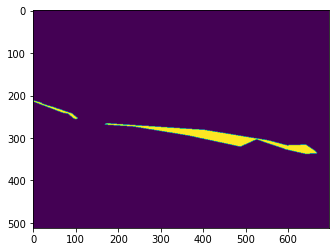

In [79]:
WATER_ID = 1
SAND_ID = 2
WATER_OR_SAND_ID = WATER_ID | SAND_ID # 1 | 2 == 3
OTHERS_ID = 0

model_output = output.unsqueeze(0).detach().clone()
new_target = target.unsqueeze(0).detach().clone()
new_output = model_output

ambiguity_mask = new_target == WATER_OR_SAND_ID
sand_mask = (new_output == SAND_ID)
water_mask = (new_output == WATER_ID)
other_mask = (new_output == OTHERS_ID)

print(f'new_output.shape : {new_output.shape}\new_target.shape : {new_target.shape}')
plt.imshow(ambiguity_mask[0])
plt.show()


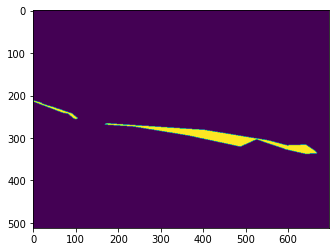

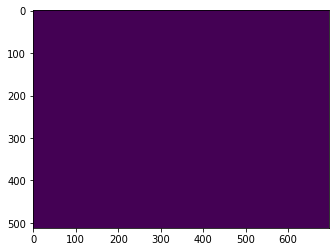

In [80]:

ambiguity_correct_mask = ambiguity_mask & (water_mask | sand_mask) # intersection of target WATER_OR_SAND_ID with output WATER_ID or SAND_ID
ambiguity_incorrect_mask = ambiguity_mask & other_mask # intersection of target WATER_OR_SAND_ID with output OTHERS_ID (complementary)

plt.imshow(ambiguity_correct_mask[0])
plt.show()
plt.imshow(ambiguity_incorrect_mask[0])
plt.show()

0
2


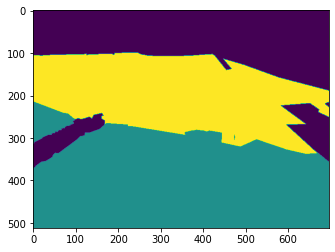

In [81]:
# If target is ambiguous and output is water or sand, the target becomes the output
new_target[ambiguity_correct_mask] = new_output[ambiguity_correct_mask].type(target.dtype)

print(np.min(new_target.numpy()))
print(np.max(new_target.numpy()))
plt.imshow(new_target.numpy()[0])
plt.show()


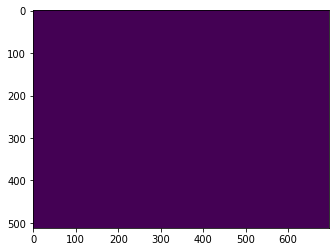

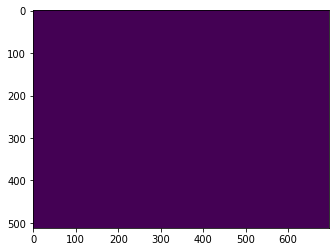

In [84]:
from kornia.contrib import distance_transform

# The rest of the ambiguous mask is the nearest class (water or sand); something like a watershed
watershed_img = torch.zeros([new_target.shape[0], 2, *new_target.shape[1:]]).type(torch.float32)
watershed_img[:, 1, :, :] = (new_target == SAND_ID).type(torch.float32)
watershed_img[:, 0, :, :] = (new_target == WATER_ID).type(torch.float32)

watershed_img = distance_transform(watershed_img)
watershed_img = watershed_img[:, 1, :, :] - watershed_img[:, 0, :, :]

new_sand_mask = ambiguity_incorrect_mask & (watershed_img >= 0)
new_water_mask = ambiguity_incorrect_mask & (watershed_img < 0)

plt.imshow(new_sand_mask[0])
plt.show()
plt.imshow(new_water_mask[0])
plt.show()


0
2


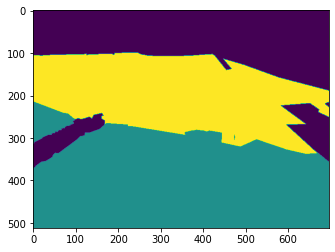

In [86]:
new_target[new_sand_mask] = SAND_ID
new_target[new_water_mask] = WATER_ID

print(np.min(new_target.numpy()))
print(np.max(new_target.numpy()))
plt.imshow(new_target.numpy()[0])
plt.show()
